COLAB

In [2]:
folder_path = '/content/drive/MyDrive/Data/colabs_data/MOA_kaggle/'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cp '/content/drive/MyDrive/Data/colabs_data/MOA_kaggle/quanvh8_funcs.py' .

KAGGLE

In [ ]:
# folder_path = '../input/lish-moa/'

In [ ]:
# !cp '../input/coded-file/quanvh8_funcs.py' .

In [5]:
'''ENSEMBLE NETS
Inspire by https://www.kaggle.com/c/otto-group-product-classification-challenge/discussion/14335'''

import numpy as np, pandas as pd, copy, tensorflow as tf, matplotlib.pyplot as plt, sklearn

from tensorflow import feature_column as fc
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import (Dense, DenseFeatures, Dropout, 
                                     BatchNormalization, Embedding, Input, Concatenate, Average,
                                     InputLayer, Lambda)
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras import backend as K, Sequential, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop

import tensorflow_addons as tfa
from tensorflow_addons.layers import WeightNormalization

from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans

from quanvh8_funcs import (DerivedFeatures, kfolds_bagging_training, voting_predict,
                           kolds_stacked_ensemble_training, stacked_ensemble_predict )

import sys

def log_loss_metric(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()
    return bce(y_true, y_pred).numpy()

print(pd.__version__)
print(tf.__version__)

1.1.4
2.3.0


In [6]:
# Loading data and encoding


raw_test = pd.read_csv(folder_path + 'test_features.csv')
raw_train = pd.read_csv(folder_path + 'train_features.csv')
raw_targets = pd.read_csv(folder_path + 'train_targets_scored.csv')
raw_nonscored = pd.read_csv(folder_path + 'train_targets_nonscored.csv')

# Phân loại dữ liệu
cols_id = ['sig_id']
cols_to_remove = ['cp_type']
cols_fts = [i for i in raw_train.columns if i not in cols_id +cols_to_remove]
cols_gene = [col for col in raw_train.columns if col.startswith("g-")]
cols_cell = [col for col in raw_train.columns if col.startswith("c-")]
cols_experiment = [col for col in cols_fts if col not in cols_gene+cols_cell]
cols_target = [i for i in raw_targets.columns if i not in cols_id]
num_fts, num_labels = len(cols_fts), len(cols_target)

# xử lý categorical
def transform_data(input_data):
    '''Clean data and encoding
        * input_data: table '''
    out = input_data.copy()
    out['cp_dose'] = out['cp_dose'].map({'D1':0, 'D2':1})
    out['cp_time'] = out['cp_time']/72
    
    return out

to_train = transform_data(raw_train[raw_train['cp_type'] != 'ctl_vehicle'])
to_train_targets = raw_targets.iloc[to_train.index]
full_pred  = transform_data(raw_test)
to_pred = full_pred[full_pred['cp_type'] != 'ctl_vehicle']

In [7]:
# preprocessing pipeline
def pipe_line_builder(quantiles_num, pca_dims, kmean_clusters):
    '''Dựng pipe line cho từng nhóm columns
    :quantiles_num: int: số quantile khi normalise
    :pca_dims: int: số chiều pca'''
    norm = QuantileTransformer(n_quantiles=quantiles_num,random_state=0, output_distribution="normal")
    pca = PCA(n_components = pca_dims)
    derived_ft = DerivedFeatures(n_clusters = kmean_clusters)
    tsne = sklearn.manifold.TSNE(n_components = int(pca_dims/2))
    isomap = sklearn.manifold.Isomap(n_neighbors = 128, n_components = int(pca_dims/2) )

    p_derived_ft = Pipeline([
        ('norm', norm), 
        ('derived', derived_ft)])
    
    p_isomap = Pipeline([
        ('norm', norm), 
        ('isomap', isomap)])

    p_norm_pca = Pipeline([ 
        ('norm', norm),
        ('pca', pca) ])
    return FeatureUnion([
        ('norm', norm), 
        ('norm_pca', p_norm_pca),
        ('derived', p_derived_ft),
#         ('isomap', p_isomap)
    ])

# Dựng pipe transform data

pipe = Pipeline([
    ('norm_pca', ColumnTransformer([
                     ('gene', pipe_line_builder(quantiles_num = 200, pca_dims = 600, kmean_clusters = 5), cols_gene),
                     ('cell', pipe_line_builder(quantiles_num = 200, pca_dims = 50, kmean_clusters = 5), cols_cell),
                    ]) 
    ), 
    ('var', VarianceThreshold(0.0)) 
])

pipe = ColumnTransformer([
    ('gene_cell', pipe, cols_gene+ cols_cell),
    ('experiment', 'passthrough', cols_experiment)
])

In [11]:
# Transform data
# pipe.fit(to_train[cols_fts].append(to_pred[cols_fts]))
# X_train = pipe.transform(to_train[cols_fts])
# X_pred = pipe.transform(to_pred[cols_fts])
y_train = to_train_targets[cols_target].values

In [8]:
bias_init_carefully = np.log([16844/(21948*206 - 16844)])
bias_init_carefully

array([-5.58882523])

In [34]:

def get_list_contains_ohe(keywords, cols_list):
    ouput = []
    for keyword in keywords:
        ouput.append( [1 if keyword in i else 0 for i in cols_list] )
    return ouput

def layer_BDWD( n_components, activation = 'relu',  kn_init = 'glorot_uniform', kn_reg = None, bias_init = None):
  def layer_cpl(input_layer):
    '''BN - DROPOUT - WEIGHTNORMAL - DENSE'''
    layer = BatchNormalization() (input_layer)
    layer = Dropout(0.25 ) (layer)
    dense = Dense(n_components, activation = activation, 
                  kernel_initializer = initializer, kernel_regularizer = kn_reg ,
                  bias_initializer = bias_init)
    layer = WeightNormalization(dense) (layer)
    return layer
  return layer_cpl

bias_init_carefully = tf.keras.initializers.Constant(np.log([16844/(21948*206 - 16844)]))

# Tiếp cận theo hướng recommend - cell -> chemical | cell/gene: user, chemial: item
n_components = 256 # <-- update

u_fts_num = X_train.shape[1]
i_fts_num = num_labels

initializer = tf.keras.initializers.LecunNormal() #'he_normal'  # <-- update
kn_reg =  None  # tf.keras.regularizers.l2(0.00001)  <-- update
activation = 'selu'  # <-- update
#User embedding
input_u = Input(shape = (u_fts_num,) )
layer_u = layer_BDWD(1024, activation = activation, kn_init = initializer, kn_reg = kn_reg, bias_init = bias_init_carefully) (input_u)
layer_u = layer_BDWD(1024, activation = activation, kn_init = initializer, kn_reg = kn_reg, bias_init = bias_init_carefully) (layer_u)
layer_u = layer_BDWD(n_components, activation = activation, kn_init = initializer, kn_reg = kn_reg, bias_init = bias_init_carefully) (layer_u)
layer_u = BatchNormalization() (layer_u)

#Item embedding
  # Addition information for item_info
list_chem_gr = ['_inhibitor', '_agonist', '_agent', '_antagonist', '_blocker', '_activator']
chemical_category = tf.transpose( tf.constant( get_list_contains_ohe( list_chem_gr, cols_target  ) ))
  # Full item fts: addition + onehot
item_ft = tf.concat(
    [chemical_category ,
     tf.eye(i_fts_num, dtype = tf.int32) # Create tensor 0-1 coresponse with chemical labels
    ], axis = 1
)
layer_i = WeightNormalization(Dense(n_components, activation = activation, 
  kernel_initializer = initializer, kernel_regularizer = kn_reg, bias_initializer = bias_init_carefully)) (item_ft)
layer_i = BatchNormalization() (layer_i)

# Dot product user - item
def dot_2layer(x):
    return K.dot( x[0], K.transpose(x[1]))
dot_ui = Lambda( dot_2layer, name = 'lambda_dot' ) ([layer_u,layer_i])
dot_ui= layer_BDWD(512, activation = 'relu', kn_init = 'he_normal', kn_reg = kn_reg, bias_init = bias_init_carefully) (dot_ui)
dot_ui= layer_BDWD(n_components, activation = 'relu', kn_init = 'he_normal', kn_reg = kn_reg, bias_init = bias_init_carefully) (dot_ui)
dot_ui = WeightNormalization(Dense(i_fts_num, activation = 'sigmoid' ))(dot_ui)

# Compile model
model = Model(inputs=[input_u, ], outputs= [dot_ui])

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

bce = tf.keras.losses.BinaryCrossentropy()
model.compile(loss= BinaryCrossentropy(label_smoothing=0.001), optimizer=opt 
              , metrics= [bce])
# print( model.summary() )

# tf.keras.utils.plot_model(model,show_shapes=True)
def exp_decay(lr0, s):
    def exp_decay_fn(epoch):
        return lr0 * 0.1*(epoch%s)
    return exp_decay_fn

lr_schedule = tf.keras.callbacks.LearningRateScheduler ( exp_decay(0.01, 5) )

reduce_lr = ReduceLROnPlateau(monitor='val_binary_crossentropy', factor=0.1, patience=5, mode='min', min_lr=1E-5, verbose= 0)
early_stopping = EarlyStopping(monitor='val_binary_crossentropy', min_delta=1E-5, patience=15, mode='min',restore_best_weights=True, verbose= 0)
    
model.fit(
        X_train, y_train, validation_split = 0.25, 
        callbacks=[reduce_lr, early_stopping, lr_schedule], epochs=150, verbose =1,
        batch_size=128 ,
        class_weight=class_weight)

Epoch 1/150


InvalidArgumentError: ignored

In [9]:
pos = 16844
total = 21948*206 
neg = total - pos
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

In [72]:
tf.keras.activations.get( fn_leakly_relu )

<function __main__.fn_leakly_relu>

Epoch 1/72
129/129 [==============================] - 2s 13ms/step - loss: 0.0646 - binary_crossentropy: 0.0383 - val_loss: 0.0545 - val_binary_crossentropy: 0.0286
Epoch 2/72
129/129 [==============================] - 1s 8ms/step - loss: 0.0453 - binary_crossentropy: 0.0201 - val_loss: 0.0441 - val_binary_crossentropy: 0.0196
Epoch 3/72
129/129 [==============================] - 1s 8ms/step - loss: 0.0422 - binary_crossentropy: 0.0183 - val_loss: 0.0424 - val_binary_crossentropy: 0.0191
Epoch 4/72
129/129 [==============================] - 1s 8ms/step - loss: 0.0409 - binary_crossentropy: 0.0180 - val_loss: 0.0406 - val_binary_crossentropy: 0.0181
Epoch 5/72
129/129 [==============================] - 1s 8ms/step - loss: 0.0396 - binary_crossentropy: 0.0174 - val_loss: 0.0404 - val_binary_crossentropy: 0.0184
Epoch 6/72
129/129 [==============================] - 1s 8ms/step - loss: 0.0389 - binary_crossentropy: 0.0172 - val_loss: 0.0403 - val_binary_crossentropy: 0.0187
Epoch 7/72
129/

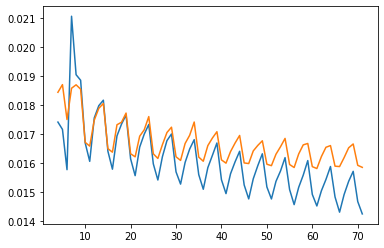

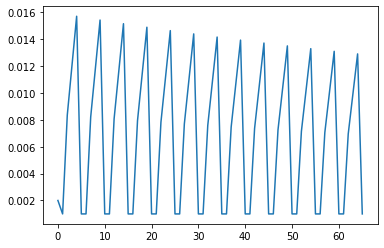

In [100]:
X_train = to_train[cols_fts]
u_fts_num = X_train.shape[1]
i_fts_num = num_labels

initializer = tf.keras.initializers.LecunNormal()# 'he_normal'  # <-- update
kn_reg = tf.keras.regularizers.l1(2e-7) # <-- update
activation = 'selu'  # <-- update

bias_init_carefully = tf.keras.initializers.Constant(np.log([16844/(21948*206 - 16844)]))
def layer_BDWD( n_components, activation = 'relu',  kn_init = 'glorot_uniform', kn_reg = None, bias_init = None):
  def layer_cpl(input_layer):
    '''BN - DROPOUT - WEIGHTNORMAL - DENSE'''
    layer = BatchNormalization() (input_layer)
    layer = Dropout(0.25 ) (layer)
    dense = Dense(n_components, activation = activation, 
                  kernel_initializer = initializer, kernel_regularizer = kn_reg ,
                  bias_initializer = bias_init)
    layer = WeightNormalization(dense) (layer)
    return layer
  return layer_cpl

#User embedding
input_u = Input(shape = (u_fts_num,) )
layer_u = layer_BDWD(1024, activation = activation, kn_init = initializer, kn_reg = kn_reg, bias_init = bias_init_carefully) (input_u)
layer_u = layer_BDWD(1024, activation = activation, kn_init = initializer, kn_reg = kn_reg, bias_init = bias_init_carefully) (layer_u)
layer_u = layer_BDWD(512, activation = activation, kn_init = initializer, kn_reg = kn_reg, bias_init = bias_init_carefully) (layer_u)

out_put = WeightNormalization(Dense(i_fts_num, activation = 'sigmoid' ))(layer_u)

model = Model(inputs=[input_u, ], outputs= [out_put])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

bce = tf.keras.losses.BinaryCrossentropy()
model.compile(loss= BinaryCrossentropy(), optimizer=opt 
              , metrics= [bce])

def exp_decay(lr0, s, down_hill):
    def exp_decay_fn(epoch):
        if epoch <= 5:
            out = lr0*2
        elif epoch%s <= 1:
            out = lr0
        else:
            out = lr0 + 0.015*(epoch%s/ (s - 1))* down_hill/ (down_hill + int(epoch/s) )
        return np.clip( out, 0.001, 0.05)
    return exp_decay_fn

fn_lr = exp_decay(0.001, 5, 50)
lr_schedule = tf.keras.callbacks.LearningRateScheduler ( fn_lr )

reduce_lr = ReduceLROnPlateau(monitor='val_binary_crossentropy', factor=0.1, patience=5, mode='min', min_lr=1E-5, verbose= 0)
early_stopping = EarlyStopping(monitor='val_binary_crossentropy', min_delta=1E-5, patience=15, mode='min',restore_best_weights=True, verbose= 0)
    
history = model.fit(
        X_train, y_train, validation_split = 0.25, 
        callbacks=[early_stopping, lr_schedule], epochs=72, verbose =1,
        batch_size= 128)

# Graph___________________________________
hí = history.history
đầu_ra = {x: hí[x] for x in ['binary_crossentropy', 'val_binary_crossentropy']}
plt.plot(pd.DataFrame(đầu_ra).iloc[4:,:])
plt.show()
lr = []
for i in range(70) :
  lr.append( fn_lr(i+1) )
plt.plot(np.array(lr)[4:])
plt.show()

In [101]:
np.clip(0.3, 0.001, 0.2)

0.2

In [110]:
lr

[0.011,
 0.021,
 0.03,
 0.03,
 0.001,
 0.010803921568627452,
 0.020607843137254903,
 0.03,
 0.03,
 0.001,
 0.010615384615384617,
 0.020230769230769233,
 0.02984615384615385,
 0.03,
 0.001,
 0.010433962264150942,
 0.019867924528301887,
 0.02930188679245283,
 0.03,
 0.001]

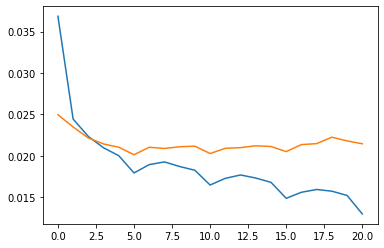

In [107]:
hí = history.history
đầu_ra = {x: hí[x] for x in ['loss', 'val_loss']}
plt.plot(pd.DataFrame(đầu_ra))

In [40]:
history.on_test_batch_begin 

<bound method Callback.on_test_batch_begin of <tensorflow.python.keras.callbacks.History object at 0x7fd0d24bca20>>

In [36]:
help(history)

Help on History in module tensorflow.python.keras.callbacks object:

class History(Callback)
 |  Callback that records events into a `History` object.
 |  
 |  This callback is automatically applied to
 |  every Keras model. The `History` object
 |  gets returned by the `fit` method of models.
 |  
 |  Method resolution order:
 |      History
 |      Callback
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  on_epoch_end(self, epoch, logs=None)
 |      Called at the end of an epoch.
 |      
 |      Subclasses should override for any actions to run. This function should only
 |      be called during TRAIN mode.
 |      
 |      Arguments:
 |          epoch: Integer, index of epoch.
 |          logs: Dict, metric results for this training epoch, and for the
 |            validation epoch if validation is performed. Validation result keys
 |            are prefixed with `val_`.
 |

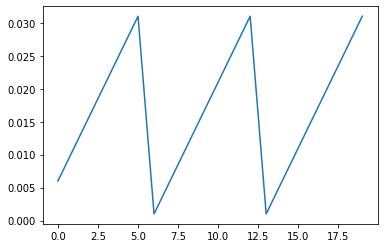

In [65]:
lr = []
for i in range(20) :
  lr.append( exp_decay(0.001, 7, 1000000)(i+1) )
plt.plot(np.array(lr))

In [27]:
reduce_lr = ReduceLROnPlateau(monitor='val_binary_crossentropy', factor=0.1, patience=5, mode='min', min_lr=1E-5, verbose= 0)
early_stopping = EarlyStopping(monitor='val_binary_crossentropy', min_delta=1E-5, patience=15, mode='min',restore_best_weights=True, verbose= 0)
    
model.fit(
        X_train, y_train, validation_split = 0.25, 
        callbacks=[reduce_lr, early_stopping], epochs=150, verbose =1,
        batch_size=32 )

Epoch 1/150
515/515 [==============================] - 5s 10ms/step - loss: 0.5011 - binary_crossentropy: 0.0404 - val_loss: 0.4244 - val_binary_crossentropy: 0.0216
Epoch 2/150
515/515 [==============================] - 5s 9ms/step - loss: 0.3835 - binary_crossentropy: 0.0227 - val_loss: 0.3488 - val_binary_crossentropy: 0.0212
Epoch 3/150
515/515 [==============================] - 5s 9ms/step - loss: 0.3305 - binary_crossentropy: 0.0224 - val_loss: 0.3143 - val_binary_crossentropy: 0.0210
Epoch 4/150
515/515 [==============================] - 5s 9ms/step - loss: 0.3070 - binary_crossentropy: 0.0220 - val_loss: 0.3003 - val_binary_crossentropy: 0.0215
Epoch 5/150
515/515 [==============================] - 5s 9ms/step - loss: 0.2968 - binary_crossentropy: 0.0218 - val_loss: 0.2931 - val_binary_crossentropy: 0.0208
Epoch 6/150
515/515 [==============================] - 5s 9ms/step - loss: 0.2923 - binary_crossentropy: 0.0217 - val_loss: 0.2899 - val_binary_crossentropy: 0.0205
Epoch 7/1

KeyboardInterrupt: ignored

In [ ]:
prediction = model.predict(X_pred)
df_preds_non_ctl =  pd.DataFrame(prediction, columns= cols_target, index = to_pred.index)

# concat with all to pred values
df_preds = pd.concat([ full_pred[cols_id], df_preds_non_ctl], axis = 1).fillna(0)

df_preds.iloc[:,[34,82]] = 0
# to csv
df_preds.to_csv("submission.csv", index = None)

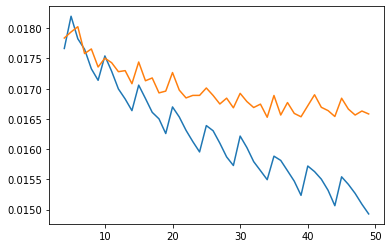

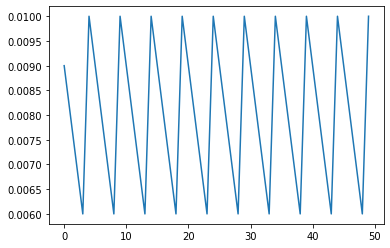

In [91]:

# Graph___________________________________
hí = history.history
đầu_ra = {x: hí[x] for x in ['binary_crossentropy', 'val_binary_crossentropy']}
plt.plot(pd.DataFrame(đầu_ra).iloc[4:,:])
plt.show()
lr = []
for i in range(50) :
  lr.append( fn_lr(i+1) )
plt.plot(np.array(lr))
plt.show()